In [5]:
import sys
sys.path.append('../')
import flower
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import deg_preserve_generator as gen
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

As an example, we create a random BA network and choose a source and target gene sets

In [9]:
g = nx.read_edgelist('../demofiles/demograph.edgelist',nodetype=int)

In [10]:
layout = nx.spring_layout(g, k=0.1)

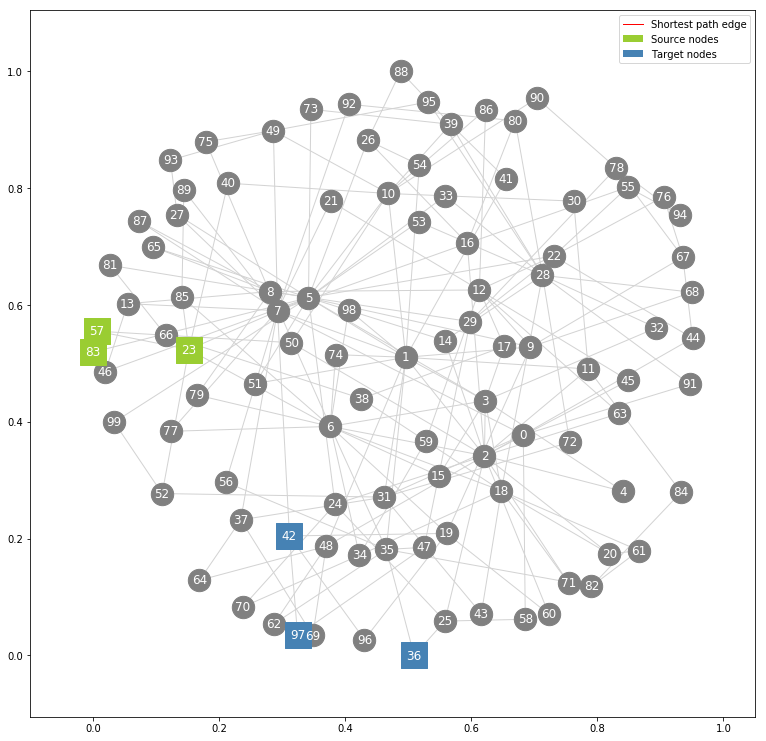

In [11]:
source = [83,57,23] # pick source and target nodes that are farthest apart for clearer results
target = [97,36,42]
plt.figure(figsize=[13,13])
nx.draw_networkx(g,layout, node_color='gray', node_size=500, edge_color='lightgray', font_color='white')
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=700, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=700, node_shape='s', node_color='steelblue')
legend_elements = [Line2D([0], [0], color='red', lw=1, label='Shortest path edge'),
                   Patch(facecolor='yellowgreen', label='Source nodes'),
                   Patch(facecolor='steelblue', label='Target nodes')]
plt.gca().legend(handles=legend_elements, loc='upper right');

Here we calculate the Shortest Path Metrics (SPM). The SPM are two matrices containing respectively the shortest path (SP) length and the number of SP between any two nodes in the network. <br />Notice that the SPM have to be calculated only once per network, and are independente of the source and target gene sets.

In [12]:
max_length = 10 # calculate paths up to the maximum length of max_length
# The iteration automatically stops if there are no path of lengths > max_length
# This is the most time-expensive operation of the algorithm, it may take a while...
spm = flower.calculate_spm_nx(g, max_length, g.nodes(), notebook=True)

First iteration...
Paths calculation...


Execution finished earlier, all paths have been already calculated at maximum distance 6



The spm object contains 
<ul>
<li>deglist: list of degrees of the nodes
<li>nodelist: the list of node names (with the same ordering as the adjacency matrix)</li>
<li>path_lengths: matrix where i,j-th element is the SP length between node i and j</li>
<li>num_paths: matrix where the i,j-th element is the number of SP between node i and j</li>
<li>curr_iter: number of iterations the SPM calculation has been run, corresponding to max_length. 
    If curr_iter == -1 then the diameter of the graph has been reached</li>
</ul>

In [13]:
spm.keys()

['deglist', 'nodelist', 'path_lengths', 'num_paths', 'curr_iter']

We could cache the SPM calculation by saving and loading them through the save_spm and load_spm functions:

In [14]:
# flower.save_spm('spm_filepath',spm)
# spm = flower.load_spm('spm_filepath')

Here we calculate flow centrality, which depends on source and target nodes. Notice that for undirected network the source and target sets are interchangeable

In [15]:
fc = flower.eval_flow_centrality_nx(target,source,spm, notebook=True)

In [16]:
fc

{0: array([0., 0., 0.]),
 1: array([0.13703704, 1.23333333, 4.        ]),
 2: array([0.05555556, 0.5       , 1.        ]),
 3: array([0., 0., 0.]),
 4: array([0., 0., 0.]),
 5: array([ 0.33333333,  3.        , 10.        ]),
 6: array([0.61111111, 5.5       , 8.        ]),
 7: array([0.11851852, 1.06666667, 4.        ]),
 8: array([0., 0., 0.]),
 9: array([0.05925926, 0.53333333, 2.        ]),
 10: array([0., 0., 0.]),
 11: array([0., 0., 0.]),
 12: array([0., 0., 0.]),
 13: array([0., 0., 0.]),
 14: array([0., 0., 0.]),
 15: array([0., 0., 0.]),
 16: array([0., 0., 0.]),
 17: array([0., 0., 0.]),
 18: array([0., 0., 0.]),
 19: array([0.39259259, 3.53333333, 6.        ]),
 20: array([0., 0., 0.]),
 21: array([0., 0., 0.]),
 22: array([0.02222222, 0.2       , 1.        ]),
 23: array([0.27777778, 2.5       , 4.        ]),
 24: array([0.05555556, 0.5       , 1.        ]),
 25: array([0.11111111, 1.        , 2.        ]),
 26: array([0., 0., 0.]),
 27: array([0.05925926, 0.53333333, 2.   

eval_flow_centrality_nx() returns a dict where each key is a node and value is (fc, unnorm_fc, n_paths), with: 
<ul>
    <li>fc is the flow centrality value of the node</li>
    <li>unnorm_fc is the unnormalized flow centrality (same as fc but without the normalization by the source and target set sizes)</li>
    <li>n_paths is the number of shortest paths between source and target passing through the node</li>
</ul>

In [47]:
fcvals = np.asarray([fc[node][0] for node in g.nodes()])

In [48]:
# just some code to highlight the shortest paths
src_tgt_sp = {}
for src in source:
    for tgt in target:
        paths = nx.all_shortest_paths(g, src,tgt)
        for path in paths:
            for i in range(len(path)-1):
                u,v = min(path[i],path[i+1]),max(path[i],path[i+1])
                if (u,v) in src_tgt_sp:
                    src_tgt_sp[(u,v)] += 1
                else:
                    src_tgt_sp[(u,v)] = 1

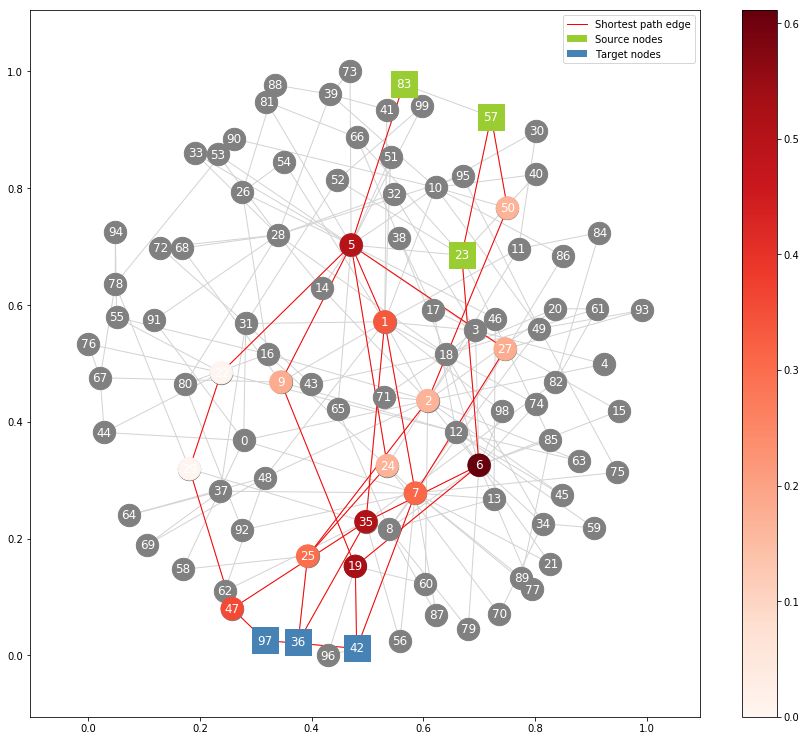

In [49]:

plt.figure(figsize=[15,13])
cmap = 'Reds'
nx.draw_networkx_nodes(g, pos=layout, nodelist=g.nodes(), node_size=500, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=g.nodes(), node_size=500, node_color=np.log(fcvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=700, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=700, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=fcvals.min(), vmax=fcvals.max()))
sm._A = []
plt.colorbar(sm)
legend_elements = [Line2D([0], [0], color='red', lw=1, label='Shortest path edge'),
                   Patch(facecolor='yellowgreen', label='Source nodes'),
                   Patch(facecolor='steelblue', label='Target nodes')]
plt.gca().legend(handles=legend_elements, loc='upper right');

We now generate the random sets of genes (can be replaced by any label-shuffling function)

In [18]:
N_samples = 100
rdm_source = gen.gen_degree_preserved_sets(source, g, N_samples, bin_minimum_occupancy=5)
rdm_target = gen.gen_degree_preserved_sets(target, g, N_samples, bin_minimum_occupancy=5)

And calculate the FC values for the random pairs of samples

In [51]:
rdm_fcvals = np.zeros([len(g),len(rdm_source)])
for i,(src,tgt) in enumerate(zip(rdm_source,rdm_target)):
    rdm_fc = flower.eval_flow_centrality_nx(tgt,src,spm,output_mode='FLOWS_NORM',progressbar=False)
    rdm_fcvals[:,i] = np.asarray([rdm_fc[node] for node in rdm_fc.keys()])

The Flow Centrality Score (FCS) is then calculated as the zscore between the FC values and the random values

In [52]:
fcs = (fcvals - rdm_fcvals.mean(axis=1)) / rdm_fcvals.std(axis=1)
fcs[np.isnan(fcs) | np.isinf(fcs)] = 0 # we set nans and infs as 0 since they are given by these
                                        # situations where the average or std of the random samples is 0

We can now visualize the differences. Notice that the hubs are no longer the highest scoring nodes

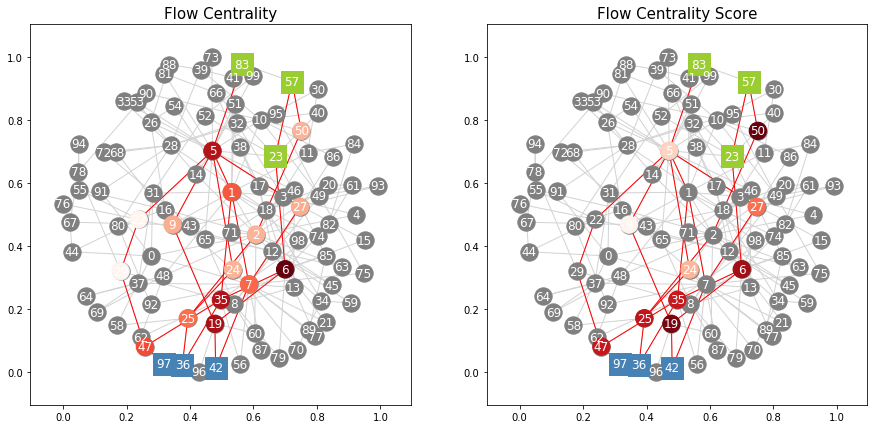

In [53]:
plt.figure(figsize=[15,7])
cmap = 'Reds'
plt.subplot(121)
nx.draw_networkx_nodes(g, pos=la1<yout, nodelist=g.nodes(), node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=g.nodes(), node_size=300, node_color=np.log(fcvals), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
plt.title('Flow Centrality',fontsize=15)
plt.subplot(122)
nx.draw_networkx_nodes(g, pos=layout, nodelist=g.nodes(), node_size=300, node_color='gray')
nx.draw_networkx_nodes(g, pos=layout, nodelist=g.nodes(), node_size=300, node_color=np.log(fcs), cmap=cmap)
nx.draw_networkx_nodes(g, pos=layout, nodelist=source, node_size=500, node_shape='s', node_color='yellowgreen')
nx.draw_networkx_nodes(g, pos=layout, nodelist=target, node_size=500, node_shape='s', node_color='steelblue')
nx.draw_networkx_edges(g, pos=layout, edge_color='lightgray')
nx.draw_networkx_edges(g, pos=layout, edgelist=src_tgt_sp.keys(), edge_color='red',width=1)
nx.draw_networkx_labels(g, layout, font_color='white')
plt.title('Flow Centrality Score',fontsize=15);